<a href="https://colab.research.google.com/github/rahiakela/StatQuest-Neural-Networks-and-AI/blob/main/chapter_02/chapter_02_intro_do_backpropagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The StatQuest Illustrated Guide to Neural Networks and AI
## Chapter 2 - Build and train a very simple neural network with backpropagation

Copyright 2024, Joshua Starmer

In this notebook, we will build, and train the very simple neural network featured in Chapter 2 of **[The StatQuest Illustrated Guide to Neural Networks and AI](https://www.amazon.com/dp/B0DRS71QVQ)**. We'll start with the untrained Weights and Biases, as seen in the figure below...

<img src="https://github.com/StatQuest/signa/blob/main/chapter_02/images/chapter_2_train_all.png?raw=1" alt="an untrained neural network" style="width: 800px;">

...and then train them with Backpropagation to, hopefully, get the trained Weights and Biases seen in the figure below.

<img src="https://github.com/StatQuest/signa/blob/main/chapter_02/images/chapter_1_pre_trained_nn_labeled.png?raw=1" alt="a trained neural network" style="width: 800px;">

In this tutorial, you will...

- **[Code a neural network with untrained wieghts and biases](#untrained)** This will show the basic structure of a class that inherits from `LightningModule` to build a neural network.

- **[Train the weights and biases in our neural network](#train)** This will show how to train the weights and biases in a simple neural network.

#### NOTE:
This tutorial assumes that you already know the basics of coding in **Python** and have read the first two chapters in **The StatQuest Illustrated Guide to Neural Networks and AI**.

----

# Import the modules that will do all the work

The very first thing we need to do is load a bunch of Python modules. Python itself is just a basic programming language. These modules give us extra functionality to create and train a Neural Network.

In [1]:
%%capture
# %%capture prevents this cell from printing a ton of STDERR stuff to the screen

## NOTE: If you **don't** need to install anything, you can comment out the
##       next line.
##
##       If you **do** need to install something, just know that you may need to
##       restart your session for python to find the new module(s).
##
##       To restart your session:
##       - In Google Colab, click on the "Runtime" menu and select
##         "Restart Session" from the pulldown menu
##       - In a local jupyter notebook, click on the "Kernel" menu and select
##         "Restart Kernel" from the pulldown menu
##
##       Also, installing can take a few minutes, so go get yourself a snack!
!pip install lightning seaborn

In [2]:
import torch ## torch let's us create tensors and also provides helper functions
import torch.nn as nn ## torch.nn gives us nn.Module(), nn.Embedding() and nn.Linear()
import torch.nn.functional as F # This gives us relu()
from torch.optim import SGD # SGD is short of Stochastic Gradient Descent, but
                            # the way we'll use it, passing in all of the training
                            # data at once instead of passing it random subsets,
                            # it will act just like plain old Gradient Descent.

import lightning as L ## Lightning makes it easier to write, optimize and scale our code
from torch.utils.data import TensorDataset, DataLoader ## We'll store our data in DataLoaders

import matplotlib.pyplot as plt ## matplotlib allows us to draw graphs.
import seaborn as sns ## seaborn makes it easier to draw nice-looking graphs.

## NOTE: If you get an error running this block of code, it is probably
##       because you installed a new package earlier and forgot to
##       restart your session for python to find the new module(s).
##
##       To restart your session:
##       - In Google Colab, click on the "Runtime" menu and select
##         "Restart Session" from the pulldown menu
##       - In a local jupyter notebook, click on the "Kernel" menu and select
##         "Restart Kernel" from the pulldown menu

----

# Create the Training Dataset

In Chapter 2, we had a very simple dataset that consisted of three points, as seen in the figure below.

<img src="https://github.com/StatQuest/signa/blob/main/chapter_02/images/chapter_2_training_data.png?raw=1" alt="a simple dataset for training" style="width: 800px;">

Although it's not required, we're going to put our training data into a `DataLoader`. `DataLoaders` are easy to make and they offer a lot of cool features. For example, if we had a large dataset, a `DataLoader` gives us a super easy way to access the data in batches instead of all at once. This is critical when we have more data than RAM to store it in. A DataLoader can also shuffle the data for us each epoch and makes it easy to only use a fraction of the data if we want to do a quick and rough training for debugging purposes.

In [3]:
## The inputs are the x-axis coordinates for each data point
## These values represent different doses
training_inputs = torch.tensor([0.0, 0.5, 1.0])

## The labels are the y-axis coordinates for each data point
## These values represent the effectiveness
training_labels = torch.tensor([0.0, 1.0, 0.0])

## Now let's package everything up into a DataLoader...
training_dataset = TensorDataset(training_inputs, training_labels)
dataloader = DataLoader(training_dataset)

----

# Create a Neural Network with Trainable Weights and Biases
<a id="create"></a>

Now we'll build a neural network that has trainable Weights and Biases. For this, we'll use `L.LightningModule`, which has everything `nn.Module` has, plus we can define the optimizer we want to use as well as tell PyTorch how each training step should work.

In [4]:
class CustomNN(L.LightningModule):

    def __init__(self):

        super().__init__()

        ## Create all of the weights and biases for the network.
        ## However, this time they are initialized with random values.
        ## We are also wrapping the tensors up in nn.Parameter() objects.
        ## PyTorch will only optimize parameters. There are a lot of
        ## different ways to create parameters, and we'll see those
        ## in later examples, but nn.Parameter() is the most basic.
        self.w1 = nn.Parameter(torch.tensor(0.06))
        self.b1 = nn.Parameter(torch.tensor(0.0))

        self.w2 = nn.Parameter(torch.tensor(3.49))
        self.b2 = nn.Parameter(torch.tensor(0.0))

        self.w3 = nn.Parameter(torch.tensor(-4.11))
        self.w4 = nn.Parameter(torch.tensor(2.74))

        self.loss = nn.MSELoss(reduction='sum')


    def forward(self, input_values):
        ## The forward() method is identical to what we used in Chapter 1.

        top_x_axis_values = (input_values * self.w1) + self.b1
        bottom_x_axis_values = (input_values * self.w2) + self.b2

        top_y_axis_values = F.relu(top_x_axis_values)
        bottom_y_axis_values = F.relu(bottom_x_axis_values)

        output_values = (top_y_axis_values * self.w3) + (bottom_y_axis_values * self.w4)

        return output_values


    def configure_optimizers(self): # this configures the optimizer we want to use for backpropagation.
        return SGD(self.parameters(), lr=0.01)
        ## NOTE: PyTorch doesn't have a Gradient Descent optimizer, just a
        ## Stochastic Gradient Descent (SGD) optimizer. However, since we
        ## are running all 3 doses through the NN each time, rather than a
        ## random subset, we are essentially doing Gradient Descent instead of
        ## SGD.


    def training_step(self, batch, batch_idx): # take a step during gradient descent.
        ## NOTE: When training_step() is called it calculates the loss with the code below...
        inputs, labels = batch # collect input
        outputs = self.forward(inputs) # run input through the neural network
        loss = self.loss(outputs, labels) ## the `loss` quantifies the difference between
                                          ## the observed drug effectiveness in `labels`
                                          ## and the outputs created by the neural network

        return loss

In [5]:
model = CustomNN() # First, make model from the class

## Now print out the name and value for each named parameter
## parameter in the model. Remember parameters are variables,
## like Weights and Biases, that we can train.
for name, param in model.named_parameters():
    print(name, torch.round(param.data, decimals=2))

w1 tensor(0.0600)
b1 tensor(0.)
w2 tensor(3.4900)
b2 tensor(0.)
w3 tensor(-4.1100)
w4 tensor(2.7400)


In [6]:
## now run different doses through the neural network.
output_values = model(training_inputs)
torch.round(output_values, decimals=2)

tensor([0.0000, 4.6600, 9.3200], grad_fn=<RoundBackward1>)

# BAM!

We successfully ran the doses from the training data through the model. However, the output from the model is way different than we expect (we expected 0.0, 1.0, and 0.0). So let's draw a picture of the bent shape that the model uses to make predictions and compare that to the training data.

In [7]:
## Create the different doses we want to run through the neural network.
## torch.linspace() creates the sequence of numbers between, and including, 0 and 1.
input_doses = torch.linspace(start=0, end=1, steps=11)

# now print out the doses to make sure they are what we expect...
input_doses

tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000])

In [8]:
output_values = model(input_doses)
output_values

tensor([0.0000, 0.9316, 1.8632, 2.7948, 3.7264, 4.6580, 5.5896, 6.5212, 7.4528,
        8.3844, 9.3160], grad_fn=<AddBackward0>)

Text(0.5, 0, 'Dose')

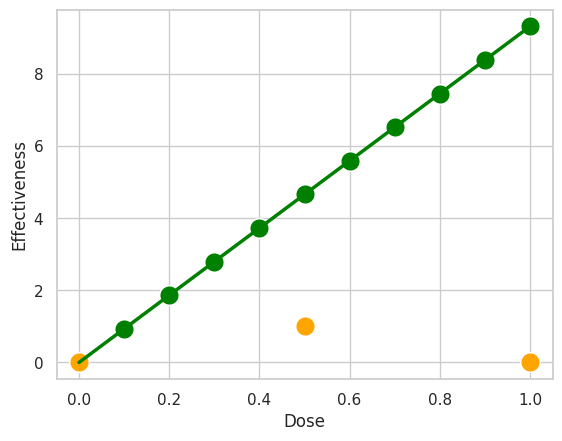

In [9]:
## Now draw a graph that shows how well, or poorly, the model
## predicts the training data. At this point, since the
## model is untrained, there should be a big difference between
## the model's output and the training data.

## First, set the style for seaborn so that the graph looks cool.
sns.set(style="whitegrid")

## First, draw the individual output points
sns.scatterplot(x=input_doses,
                y=output_values.detach().numpy(),
                color='green',
                s=200)

## Now connect those points with a line
sns.lineplot(x=input_doses,
             y=output_values.detach().numpy(), ## NOTE: We call .detatch() because...
             color='green',
             linewidth=2.5)

## Add the values in the training dataset
sns.scatterplot(x=training_inputs,
                y=training_labels,
                color='orange',
                s=200)

## now label the y- and x-axes.
plt.ylabel('Effectiveness')
plt.xlabel('Dose')

# DOUBLE BAM!!

Now that we see how badly the bent shape fits the training data, let's train the model

-----

# Training the Weights and Biases in the Neural Network

Training consists of creating a **Lightning Trainer** with `L.Trainer()` and then calling the `fit()` method on the our model with the training data.

In [10]:
model = CustomNN()
## Now train the model...
trainer = L.Trainer(max_epochs=500, # how many times to go through the training data
                    logger=False,
                    enable_checkpointing=False,
                    enable_progress_bar=False)

trainer.fit(model, train_dataloaders=dataloader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name         | Type    | Params | Mode 
-------------------------------------------------
0 | loss         | MSELoss | 0      | train
  | other params | n/a     | 6      | n/a  
-------------------------------------------------
6         Trainable params
0         Non-trainable params
6         Total params
0.000     Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name         | Type    | Params | Mode 
-------------------------------------------------
0 | loss         | MSELoss | 0      | train
  | other par

In [11]:
## Now that we've trained the model, let's print out the
## new values for each Weight and Bias.
for name, param in model.named_parameters():
    print(name, torch.round(param.data, decimals=3))

w1 tensor(1.4790)
b1 tensor(-0.5680)
w2 tensor(2.6980)
b2 tensor(-0.2580)
w3 tensor(-4.2400)
w4 tensor(1.5840)


Lastly, let's draw a graph of the bent shape that the model is using for predictions and compare it to the training data. In theory, the bent shape should fit the data much better now that we have optimized the Weights and Biases.

In [12]:
## now run the different doses through the neural network.
output_values = model(input_doses)
torch.round(output_values, decimals=2)

tensor([0.0000, 0.0200, 0.4500, 0.8700, 1.2000, 1.0000, 0.8000, 0.6000, 0.4000,
        0.2000, 0.0000], grad_fn=<RoundBackward1>)

Text(0.5, 0, 'Dose')

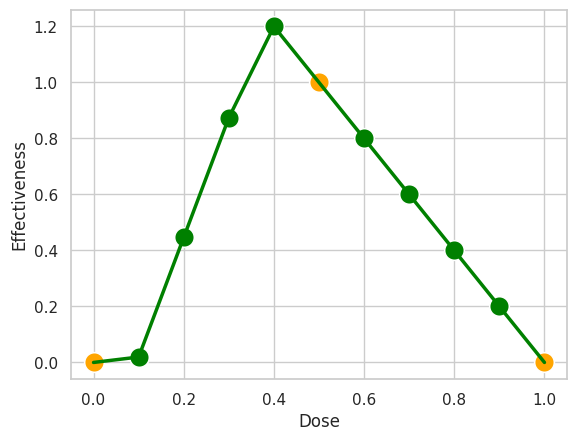

In [13]:
## Now draw a graph that shows how well, or poorly, the model
## predicts the training data. At this point, since we just
## trained th model, the training data should overlap the
## model's output

## First, set the style for seaborn so that the graph looks cool.
sns.set(style="whitegrid")

## First, draw the individual output points
sns.scatterplot(x=input_doses,
                y=output_values.detach().numpy(),
                color='green',
                s=200)

## Now connect those points with a line
sns.lineplot(x=input_doses,
             y=output_values.detach().numpy(), ## NOTE: We call .detatch() because...
             color='green',
             linewidth=2.5)

## Add the values in the training dataset
sns.scatterplot(x=training_inputs,
                y=training_labels,
                color='orange',
                s=200)

## now label the y- and x-axes.
plt.ylabel('Effectiveness')
plt.xlabel('Dose')

# TRIPLE BAM!!!